# **Fine-tuning Wav2Vec2 for English ASR with 🤗 Transformers**


[Fine-tuning Wav2Vec2 for English ASR with Transformers](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Fine_tuning_Wav2Vec2_for_English_ASR.ipynb) 를 한국어로 번역하고 공부한 notebook 입니다.


Wav2Vec2는 자동 음성 인식(ASR)을 위해 사전 훈련된 모델입니다.

[September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) 에 Alexei Baevski, Michael Auli, and Alex Conneau  이 공개했습니다.

Wav2Vec2는 Using a novel contrastive pretraining objective를 사용하여 레이블이 없는 50,000 시간 이상의 음성에서 강력한 음성 표현을 학습합니다

 [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/) 과 유사하게 이 모델은 feature vector를 transformer network에 전달하기 전에 무작위로 마스킹하여 상황에 맞는 speech representation을 학습합니다.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/wav2vec2.png)

처음으로 사전 훈련 후 매우 적은 레이블이 지정된 음성 데이터에 대한 미세 조정이 최첨단 ASR 시스템의 state-of-the-art 달성하는 것으로 나타났습니다.

레이블이 지정된 10분 정도의 데이터를  사용하여 Wav2Vec2 는 LibriSpeech 의 clean test set 에서 5% 미만의 단어 오류율(WER)을 산출합니다. 

[LibriSpeech](https://huggingface.co/datasets/librispeech_asr) - *cf.* with Table 9 of the [paper](https://arxiv.org/pdf/2006.11477.pdf).

이 notebook에서는 Wav2Vec2의 사전 훈련된 체크포인트가 모든 영어 ASR 데이터 세트에서 미세 조정되는 방법에 대해 자세히 설명합니다. 

이 노트북에서는 언어 모델을 사용하지 않고 Wav2Vec2를 미세 조정할 것입니다.

종단 간 ASR 시스템으로 언어 모델 없이 Wav2Vec2를 사용하는 것이 훨씬 간단하며 독립형 Wav2Vec2 음향 모델이 인상적인 결과를 달성하는 것으로 나타났습니다. 데모 목적으로 5h의 훈련 데이터를 포함 하는 다소 작은 [Timit](https://huggingface.co/datasets/timit_asr)  데이터 세트 에서 "base" 크기의 [pretrained checkpoint](https://huggingface.co/facebook/wav2vec2-base) 를 미세 조정합니다 .



Wav2Vec2 은 Connectionist Temporal Classification (CTC)를 사용하여 fine tuned 됩니다.
CTC는  sequence-to-sequence 문제와 주로Automatic Speech Recognition 및 handwriting recognition 에 대해 신경망을 훈련하는 데 사용되는 알고리즘입니다.

CTC 설명이 잘되어 있는 blog post :  [Sequence Modeling with CTC (2017)](https://distill.pub/2017/ctc/) 

colab에서 GPU 엑세스 하기 

Google Colab Pro를 사용하면 V100 또는 P100 GPU  사용 가능 

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Apr 22 02:56:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

패키지 설치하기

`datasets` 

`transformers`

`librosa` : audio files load

`jiwer` : fine-tuned 된 모델을 [word error rate (WER)](https://huggingface.co/metrics/wer) 로 평가

In [ ]:
%%capture
!pip install datasets==1.18.3
!pip install transformers==4.11.3
!pip install librosa
!pip install jiwer

훈련 중에 훈련 체크포인트를 Hugging Face [🤗 Hub](https://huggingface.co/) 에 직접 업로드하는 것이 좋음

Hub에는 버전 제어가 통합되어 있으므로 학습 중에 모델 체크포인트가 손실되지 않도록 할 수 있음

이를 위해 Hugging Face 웹사이트에서 인증 토큰을 저장

아직 없다면  sign up [here](https://huggingface.co/join) 


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


Git-LFS 설치 :  model checkpoints 업로드

In [ ]:
%%capture
!apt install git-lfs

Timit는 일반적으로 PER(phoneme error rate 음소 오류율)을 사용하여 평가

but ASR에서 가장 일반적인 측정 기준은 WER(word error rate 단어 오류율)

 일반적으로 WER을 많이 사용하기 때문에 여기서는 WER을 사용하여 모델을 평가



## Prepare Data, Tokenizer, Feature Extractor

ASR 모델은 음성을 텍스트로 변환하기 때문에  feature extractor, tokenizer 둘 다 필요


feature extractor는 speech signal를 모델의 입력 형식( 예: feature vector)으로 처리하는데 필요하고

 tokenizer는 모델의 출력 형식을 텍스트로 처리하는데 필요함



🤗 Transformers에서  Wav2Vec2 model은 tokenizer와 feature extractor를 제공

 Tokenizer-[Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer)

 Feature extractor - [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).


먼저 모델의 예측 디코딩을 담당하는 토크나이저 Wav2Vec2CTCTokenizer 생성 

### Create Wav2Vec2CTCTokenizer

[pretrained Wav2Vec2 checkpoint]( ) 는 speech signal을  sequence of context representations에 매핑합니다.(위의 Fig)

fine-tuned Wav2Vec2 checkpoint는 이 sequence of context representations 와 대응하는 *transcription가 매핑되고 선형 레이어가 transformer block (노란색으로 표시) 위에 추가 되어야합니다.

( *transcription(전사)란? 구어(spoken language)와 관련된 연구에서 녹음된 음성 데이터를 문자로 표현하는 작업)




 이 선형 계층은 각 context representations 을  token class로 분류하는 데 사용됩니다. 
 
이는 사전 훈련 후 선형 계층이 추가 분류를 위해 BERT의 임베딩 위에 추가되는 방식과 유사합니다. 
 
 참조 . [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder). 의 "BERT" 섹션.

이 레이어의 출력 크기는 Wav2Vec2의 사전 훈련 작업에 의존 하지 않고 미세 조정에 사용되는 레이블이 지정된 데이터 세트에만 의존하는 어휘의 토큰 수에 해당합니다.

따라서 첫 번째 단계에서 Timit를 살펴보고 데이터 세트의 전사를 기반으로 어휘를 정의합니다.

먼저 데이터세트를 로드하고 구조를 살펴보겠습니다.


데이터세트를 로드하고 구조를 살펴보기

In [ ]:
from datasets import load_dataset, load_metric

timit = load_dataset("timit_asr")

Downloading:   0%|          | 0.00/2.40k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset timit_asr downloaded and prepared to /root/.cache/huggingface/datasets/timit_asr/clean/2.0.1/b11b576ddcccbcefa7c9f0c4e6c2a43756f3033adffe0fb686aa61043d0450ad. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
timit

DatasetDict({
    train: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 4620
    })
    test: Dataset({
        features: ['file', 'audio', 'text', 'phonetic_detail', 'word_detail', 'dialect_region', 'sentence_type', 'speaker_id', 'id'],
        num_rows: 1680
    })
})

많은 ASR 데이터 세트 는 각 오디오 파일에 대해 대상 텍스트만 제공

Timit은 'phonetic_detail' 등과 같은 각 오디오 파일에 대해 훨씬 더 많은 정보를 제공

여기서는 전사된 텍스트 데이터만 미세 조정을 위해 사용 

In [ ]:
#file', 'audio', 'text'를 제외하고 제거
timit = timit.remove_columns(["phonetic_detail", "word_detail", "dialect_region", "id", "sentence_type", "speaker_id"])

데이터 세트의 일부 랜덤 샘플을 출력하는 함수

전사가 어떤 문장인지 확인

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(timit["train"].remove_columns(["audio", "file"]), num_examples=10)

,text
0,She had your dark suit in greasy wash water all year.
1,Don't ask me to carry an oily rag like that.
2,We welcome many new students each year.
3,Don't ask me to carry an oily rag like that.
4,Some observers speculated that this might be his revenge on his home town.
5,She had your dark suit in greasy wash water all year.
6,Where can we get this cereal he likes so much?
7,The toddler found a clamshell near the camp site.
8,Challenge each general's intelligence.
9,Count the number of teaspoons of soysauce that you add.


전사는 깨끗해 보임

내용이 대화보다는 서면 텍스트처럼 보이는데 [Timit](https://huggingface.co/datasets/timit_asr) 이 read speech corpus이기 때문 


전사에 ,.?!;:. 와 같은 특수 문자가 포함되어 있음

언어 모델이 없으면 음성 청크를 이러한 특수 문자로 분류하는 것이 더 어려움.

왜냐하면 특수 문자들은 특징적인 사운드 단위에 실제로 해당하지 않기 때문

ex) 문자 "s"는 다소 명확한 소리가 나는 반면 특수 문자 "."는 그렇지 않음

또한 음성 신호의 의미를 이해하기 위해 일반적으로 전사에 특수 문자를 포함할 필요가 없음.

--> 따라서 텍스트 특수문자를 제거하고 소문자로 정규화

In [ ]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'
#전사를 특수문자를 제거하고 소문자로 제거하는 함수
def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [ ]:
timit = timit.map(remove_special_characters)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [ ]:
#전처리된 전사 살펴보기
show_random_elements(timit["train"].remove_columns(["audio", "file"]))

,text
0,as such it acts as an anchor for the people
1,the lifeboats were stuck fast
2,do this exercise six times each class period
3,biologists use radioactive isotopes to study microorganisms
4,another stock vaudeville gag ran mother is home sick in bed with the doctor
5,then he heard the outer door closing
6,rob made hungarian goulash for dinner and gooseberry pie for dessert
7,please shorten this skirt for joyce
8,marksmanship example
9,i gave them several choices and let them set the priorities


CTC에서는 speech chunks를 문자로 분류하는 것이 일반적이므로 여기에서도 동일한 작업을 수행

훈련 및 테스트 데이터의 모든 고유한 문자를 추출하고 이 문자 집합에서 vocabulary 를 구축

모든 전사를 하나의 긴 전사로 연결한 다음 문자열을 문자 집합으로 변환하는 매핑 함수를 사용

매핑 함수가 모든 전사에 한 번에 액세스할 수 있도록 map(...)함수에 인수 batched=True를 전달

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocabs = timit.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=timit.column_names["train"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

이제 훈련 데이터 세트와 테스트 데이터 세트에 있는 모든 고유한 문자의 합집합으로 만듦 

결과 리스트를 열거된 사전으로 변환

In [ ]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{' ': 14,
 "'": 20,
 'a': 1,
 'b': 0,
 'c': 15,
 'd': 27,
 'e': 11,
 'f': 19,
 'g': 2,
 'h': 17,
 'i': 21,
 'j': 25,
 'k': 12,
 'l': 22,
 'm': 10,
 'n': 3,
 'o': 9,
 'p': 5,
 'q': 18,
 'r': 6,
 's': 4,
 't': 8,
 'u': 13,
 'v': 7,
 'w': 24,
 'x': 26,
 'y': 16,
 'z': 23}

알파벳의 모든 문자가 데이터 세트에서 발생한다는 것을 알수 있음

그리고 " "(띄어쓰기) 와 특수 문자  와 '도 추출 됨

두 가지 이유로 이 특수문자는 제외하지 않음

-  모델은 단어가 끝나는 시점을 예측하는 방법을 학습해야함. 그렇지 않으면 모델 예측은 항상 하나의 시퀀스 문자가 되어 단어를 서로 분리 하는 것이 불가능
- 영어에서는 ' 와 같이 매우 다른 의미를 가진 단어를 구별하기 위해 문자 를 유지해야 합니다.ex ) "it's""its"


띄어쓰기 " "자체 토큰 클래스가 있음을 더 명확하게 하기 위해 더 눈에 띄는 문자인 "|" 로 치환 합니다.

또한 모델이 나중에 Timit의 훈련 세트에서 만나지 못한 문자를 처리할 수 있도록 "unknown" 토큰도 추가합니다


---
마지막으로 CTC의 *blank token*" 에 해당하는 패딩 토큰도 추가합니다 . 

blank token 은 CTC 알고리즘의 핵심 구성 요소입니다. 

자세한 내용 "Alignment" section [here](https://distill.pub/2017/ctc/). .



In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30


이 vacabulary는 30개의 토큰으로 구성됩니다. 

즉, 사전 훈련된 Wav2Vec2 체크포인트 위에 추가할 선형 레이어의 출력 차원은 30입니다.


vacabulary를 json 파일로 저장

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

json 파일을 사용하여 Wav2Vec2CTCTokenizer클래스의 개체를 인스턴스화

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

만든 토크나이저를 이 notebook의 미세 조정된 모델로 다시 사용하려면 tokenizer[🤗 Hub](https://huggingface.co/) 에 업로드하는 것이 좋습니다. 

파일을 업로드할 저장소를 호출하기 ex) "wav2vec2-large-xlsr-turkish-demo-colab".

In [ ]:
repo_name = "wav2vec2-base-960h-timit-demo-colab"

tokenizer를  [🤗 Hub](https://huggingface.co/)에 업로드

In [ ]:
tokenizer.push_to_hub(repo_name)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/utils/_deprecation.py:43: FutureWarning: Pass token='wav2vec2-base-960h-timit-demo-colab' as keyword args. From version 0.7 passing these as positional arguments will result in an error
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:599: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab into local empty directory.
To https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab
   e676126..bfe8e21  main -> main



'https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/commit/bfe8e21ad5c26f291220cd7d1cb454d72726ca1b'

아래에서 방금 생성한 레포지토리를 볼 수 있음

 `https://huggingface.co/<your-username>/wav2vec2-base-timit-demo-colab`

### Create Wav2Vec2 Feature Extractor

음성은 연속적인 신호이며 컴퓨터에서 처리하려면 먼저 이산화되어야 하며 일반적으로 **sampling**. 이라고 합니다. 

sampling rate는 초당 측정되는 음성 신호의 데이터 포인트 수를 정의한다는 점에서 중요한 역할을 합니다. 

따라서 더 높은 sampling rate로 샘플링하면 실제 음성 신호에 대한 근사치가 향상되지만 초당 더 많은 값이 필요합니다.

사전 훈련된 체크포인트는 입력 데이터가 훈련된 데이터와 동일한 분포에서 어느 정도 sampling될 것으로 예상합니다. 


2개의 상이한 rate로 sampling된 동일한 음성 신호는 매우 상이한 분포를 가집니다
예를 들어 sampling rate를 2배로 하면 데이터 포인트의 길이가 2배가 됩니다.

따라서 ASR 모델의 사전 학습된 체크포인트를 미세 조정하기 전에 

모델을 사전 학습하는데 사용된 데이터의 샘플링 속도가 모델을 미세 조정하는데 사용되는 데이터 세트의 샘플링 속도와 일치하는지 확인하는 것이 중요합니다.


Wav2Vec2는 16kHz로 샘플링된  [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) 및 LibriVox의 오디오 데이터에 대해 사전 학습되었습니다. '

미세 조정 데이터 세트인  [Timit](https://huggingface.co/datasets/timit_asr) 도 운 좋게도 16kHz로 샘플링되었습니다

미세 조정 데이터 세트가 16kHz보다 낮거나 높은 속도로 샘플링된 경우 먼저 사전 훈련에 사용된 데이터의 샘플링 속도와 일치하도록 음성 신호를 업 또는 다운샘플링해야 했습니다. 



Wav2Vec2 feature extractor 개체를 인스턴스화하려면 다음 매개변수가 필요합니다.

- `feature_size`: 음성 모델은 일련의  feature vectors를 입력으로 사용합니다. 이 시퀀스의 길이는 분명히 다양하지만  feature vectors 크기는 그렇지 않아야 합니다. Wav2Vec2의 경우 모델이 raw speech signal에 대해 학습되었기 때문에  feature 크기는 1 입니다.

- `sampling_rate`: 모델이 학습되는 샘플링 속도
- `padding_value`: batched inference에서 더 짧은 입력은 특정 값으로 채워야함 
- `do_normalize`: input이 *zero-mean-unit-variance*  정규화 되어야하지 여부 
일반적으로 speech model은 입력을 정규화할때 더 잘 수행됨
- `return_attention_mask`: 모델이 일괄 추론을 사용해야 하는지 여부 . 일반적으로 모델은 패딩된 토큰을 마스크 하는 데 항상 사용해야 합니다 . 그러나 '기본' 체크포인트의 attention_mask매우 구체적인 설계 선택으로 인해 no 를 사용할 때 더 나은 결과를 얻을 수 있습니다. 다른 음성 모델에는 권장 하지 않습니다 . 자세한 내용은 이 문제를 참조하세요. 중요 이 노트북을 사용하여 large-lv60 을 미세 조정하려면 이 매개변수를 로 설정해야 합니다 .Wav2Vec2attention_maskTrue
- `return_attention_mask`: 모델이 batched inference 할 때 `attention_mask`를 사용할지 여부. 일반적으로 모델은 패딩된 토큰을 마스크하기 위해 항상 Attention_mask를 사용해야 합니다. 그러나 Wav2Vec2의 "base" 체크포인트의 매우 구체적인 디자인 선택으로 인해 Attention_mask를 사용하지 않을 때 더 나은 결과를 얻을 수 있습니다. 다른 음성 모델에는 **권장하지 않습니다** . 자세한 내용은 이 문제를 참조하세요. 중요 이 노트북을 사용하여 [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60) 을 미세 조정하려면 이 매개변수를 True로 설정해야 합니다.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor

feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

Wav2Vec2의  Wav2Vec2's feature extraction pipeline 정의 완료

Wav2Vec2를 최대한 사용자 친화적으로 사용하기 위해 feature extractor and tokenizer 는 하나의 Wav2Vec2Processor 클래스로 래핑되어 `model` 과 `processor` 객체만 필요합니다.

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

### Preprocess Data

데이터셋 준비하기 
지금까지 우리는 음성 신호의 실제 값을 보지 않고 전사만 보았습니다.

`'text'` 외에도 데이터 세트에는 두 개의 열 `'file'`과`'audio'`가 더 포함됩니다. 
`'file'` 는 오디오 파일의 절대 경로를 나타냅니다.

In [ ]:
timit["train"][0]["file"]

'/root/.cache/huggingface/datasets/downloads/extracted/404950a46da14eac65eb4e2a8317b1372fb3971d980d91d5d5b221275b1fd7e0/data/TRAIN/DR4/MMDM0/SI681.WAV'

`Wav2Vec2`은 16kHz의 1차원 배열 형식의 입력을 예상합니다. 

즉, 오디오 파일을 로드하고 다시 샘플링해야 합니다.

`datasets` 다른 열`audio` 를 호출하여 이를 자동으로 수행합니다.



In [ ]:
timit["train"][0]["audio"]

{'array': array([-2.1362305e-04,  6.1035156e-05,  3.0517578e-05, ...,
        -3.0517578e-05, -9.1552734e-05, -6.1035156e-05], dtype=float32),
 'path': '/root/.cache/huggingface/datasets/downloads/extracted/404950a46da14eac65eb4e2a8317b1372fb3971d980d91d5d5b221275b1fd7e0/data/TRAIN/DR4/MMDM0/SI681.WAV',
 'sampling_rate': 16000}

오디오 파일이 자동으로 로드되었음을 알 수 있습니다.
이 기능은 호출 시 즉석에서 오디오 파일을 로드하고 리샘플링합니다.

샘플링 속도는 Wav2Vec2입력으로 예상되는 16kHz로 설정됩니다.

데이터 세트를 더 잘 이해하고 오디오가 올바르게 로드되었는지 확인하기 위해 몇 가지 오디오 파일을 들어보겠습니다.



In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(timit["train"]))

print(timit["train"][rand_int]["text"])
ipd.Audio(data=np.asarray(timit["train"][rand_int]["audio"]["array"]), autoplay=True, rate=16000)

his talk turns to what he calls the mess or sometimes this buzzing confusion 


화자가 말하는 속도, 억양 등이 다른 것을 들을 수 있습니다. 

전반적으로 녹음은 비교적 명확하게 들립니다. 이는 읽기 말뭉치에서 기대할 수 있는 것입니다.

음성 입력의 모양, 전사 및 해당 샘플링 속도를 인쇄하여 데이터가 올바르게 준비되었는지 최종 확인합시다.


In [ ]:
rand_int = random.randint(0, len(timit["train"]))

print("Target text:", timit["train"][rand_int]["text"])
print("Input array shape:", np.asarray(timit["train"][rand_int]["audio"]["array"]).shape)
print("Sampling rate:", timit["train"][rand_int]["audio"]["sampling_rate"])

Target text: reading in poor light gives you eyestrain 
Input array shape: (42189,)
Sampling rate: 16000


데이터는 1차원 배열이고 샘플링 속도는 항상 16kHz에 해당하며 대상 텍스트는 정규화됩니다.

마지막으로 훈련을 위해 모델이 예상하는 형식으로 데이터 세트를 처리할 수 있습니다. 
위의 코드과 우리는 map(...)기능을 사용할 것입니다.



1.   `batch["audio"]`를 호출하여 오디오 데이터를 로드하고 resample 
2.   로드된 오디오 파일에서 `input_values` 추출. 여기서 `Wav2Vec2Processor`는 정규화를 하지만 다른 음성 모델의 경우 이 단계에서  Log-Mel 특징 추출 과 같은 더 복잡한 특징 추출이 포함될 수 있음
3. label ids 을 지정하기 위해 전사를 인코딩

(공부 필요)
**Note**: 이 mapping function는 `Wav2Vec2Processor`클래스를 사용하는 방법의 좋은 예입니다. "normal" 컨텍스트에서`processor(...)` 호출 은 의 호출 메서드 Wav2Vec2FeatureExtractor` 로 리디렉션됩니다 .
그러나 프로세서를  `as_target_processor` contex로 래핑할 때 동일한 메서드가 Wav2Vec2CTCTokenizer`의 호출 메서드로 리디렉션됩니다. 자세한 내용은 문서 를 확인하십시오 

자세한 내용 :[docs](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#transformers.Wav2Vec2Processor.__call__).


In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])
    
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

모든 데이터 sample에 데이터셋 준비 함수 적용

In [ ]:
timit = timit.map(prepare_dataset, remove_columns=timit.column_names["train"], num_proc=4)

**Note**: 현재 `데이터 세트`는 [`torchaudio`](https://pytorch.org/audio/stable/index.html) 및 [`librosa`](https://librosa.org/ doc/latest/index.html) 오디오 로딩 및 리샘플링. 사용자 고유의 맞춤 데이터 로드/샘플링을 구현하려면 `"path"` 열을 대신 사용하고 `"audio"` 열은 무시해도 됩니다.

긴 입력 시퀀스에는 많은 메모리가 필요합니다. 'Wav2Vec2'는 `self-attention`를 기반으로 하기 때문에 긴 입력 시퀀스에 대한 입력 길이에 따라 메모리 요구 사항이 2차적으로 확장됩니다*cf.* with [this](https://www.reddit.com/r/MachineLearning/comments/genjvb/d_why_is_the_maximum_input_sequence_length_of/)  

이 데모에서는 훈련 데이터 세트에서 4초보다 긴 모든 시퀀스를 필터링해 보겠습니다.

In [ ]:
max_input_length_in_sec = 4.0
timit["train"] = timit["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

  0%|          | 0/5 [00:00<?, ?ba/s]

학습할 준비 끝

## Training & Evaluation
데이터가 처리 되었고 훈련 파이프라인 setting 합니다. 
 🤗의 [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer)를 사용할 것입니다.

- Data collator를 정의합니다. 대부분의 NLP 모델과 달리 Wav2Vec2는 출력 길이보다 입력 길이가 훨씬 더 큽니다. *예:* 입력 길이가 50000인 샘플의 출력 길이는 100 이하입니다. 큰 입력 크기가 주어지면 훈련 배치를 동적으로 채우는 것이 훨씬 더 효율적입니다. 즉, 모든 훈련 샘플은 전체 가장 긴 샘플이 아니라 배치에서 가장 긴 샘플에만 채워져야 합니다.  따라서 Wav2Vec2를 미세 조정하려면 아래에서 정의할 특별한  padding data collator가 필요합니다.

- Evaluation metric 정의. 훈련하는 동안 모델은 단어 오류율로 평가되어야 합니다. 그에 따라 `compute_metrics` 함수를 정의해야 합니다.

- 사전 훈련된 체크포인트를 로드합니다. 사전 훈련된 체크포인트를 로드하고 훈련을 위해 올바르게 구성해야 합니다.

- training configuration을 정의합니다.

모델을 미세 조정한 후 테스트 데이터에서 모델을 올바르게 평가하고 실제로 음성을 올바르게 전사하는 방법을 학습했는지 확인합니다.


### Set-up Trainer
data collator를 정의하는 것부터 시작하겠습니다. 

data collator의 코드는[this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81)에서 복사

너무 많은 세부 사항에 들어가지 않고 일반적인 데이터 수집기와 달리 이 데이터 수집기는 `input_values`와 `labels`를 다르게 처리하므로 별도의 패딩 기능에 적용됩니다(다시 Wav2Vec2의context manager 사용). 이것은 음성에서 입력과 출력이 동일한 패딩 기능으로 처리되어서는 안 되는 서로 다른 양식이기 때문에 필요합니다.
일반적인 데이터 수집기와 유사하게 레이블의 패딩 토큰은 '-100'이므로 손실을 계산할 때 해당 토큰이 고려되지 **않습니다**.

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

다음으로 평가 메트릭이 정의됩니다. 앞서 언급했듯이,
ASR에서 가장 많이 사용되는 메트릭은 WER(오류율)이라는 단어이므로 이 노트북에서도 사용할 것입니다.

In [ ]:
wer_metric = load_metric("wer")

Downloading:   0%|          | 0.00/1.90k [00:00<?, ?B/s]

모델은 sequence of logit vectors를 반환 합니다:

$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

logit vector $\mathbf{y}_1$ 는   앞서 정의한 어휘의 각 단어에 대한 로그 확률을 포함하므로 $\text{len}(\mathbf{y}_i) =$ `config.vocab_size`입니다.


우리는 모델의 가장 가능성 있는 예측에 관심이 있으므로 로짓의 `argmax(...)`를 취합니다. 또한 `-100` 을 `pad_token_id`로 바꾸고 ID를 디코딩하여 인코딩된 레이블을 원래 문자열로 다시 변환하는 동시에 연속적인 토큰이 CTC 스타일에서 동일한 토큰으로 그룹화되지 않도록 합니다.



In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

이제 사전 훈련된 `Wav2Vec2` 체크포인트를 로드할 수 있습니다. 

토크나이저의 `pad_token_id`는 모델의 `pad_token_id` 를 정의하거나 Wav2Vec2ForCTC의 경우 CTC의 *blank token*  도 정의해야 합니다.

 GPU 메모리를 절약하기 위해 PyTorch의  [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html)를 활성화하고 손실 감소를 "*mean*"으로 설정합니다.


In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-base-960h", 
    ctc_loss_reduction="mean", 
    pad_token_id=processor.tokenizer.pad_token_id,
)

Downloading:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Wav2Vec2의 첫 번째 구성 요소는 원시 음성 신호에서 음향적으로 의미 있지만 맥락적으로는 독립적인 특징을 추출하는 데 사용되는 CNN 레이어 스택으로 구성됩니다. 모델의 이 부분은 사전 훈련 중에 이미 충분히 훈련되었으며 [paper](https://arxiv.org/abs/2006.11477)에 명시된 바와 같이 더 이상 미세 조정할 필요가 없습니다.
따라서 *feature 추출* 부분의 모든 매개변수에 대해 `requires_grad`를 `False`로 설정할 수 있습니다.

마지막 단계에서 훈련과 관련된 모든 매개변수를 정의합니다.
일부 매개변수에 대한 자세한 설명은 다음과 같습니다.
- `group_by_length`는 입력 길이가 유사한 훈련 샘플을 하나의 배치로 그룹화하여 훈련을 보다 효율적으로 만듭니다. 이것은 모델을 통해 전달되는 쓸모없는 패딩 토큰의 전체 수를 크게 줄여 학습 시간을 크게 단축할 수 있습니다.
- `learning_rate` 및 `weight_decay`는 미세 조정이 안정될 때까지 경험적으로 조정되었습니다. 이러한 매개변수는 Timit 데이터 세트에 크게 의존하며 다른 음성 데이터 세트에는 차선책일 수 있습니다.

다른 매개변수에 대한 자세한 설명은 [문서](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer#trainingarguments)를 참조하세요.

훈련 중에 체크포인트는 400개의 훈련 단계마다 허브에 비동기식으로 업로드됩니다. 모델이 아직 훈련 중인 동안에도 데모 위젯을 가지고 놀 수 있습니다.

**참고**: 모델 체크포인트를 허브에 업로드하지 않으려면 `push_to_hub=False`로 설정하기만 하면 됩니다.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
  output_dir=repo_name,
  group_by_length=True,
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=30,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=2,
  push_to_hub=True,
)

이제 모든 인스턴스를 Trainer로 전달할 수 있으며 학습을 시작할 준비가 되었습니다!

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=timit["train"],
    eval_dataset=timit["test"],
    tokenizer=processor.feature_extractor,
)

/content/wav2vec2-base-960h-timit-demo-colab is already a clone of https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab. Make sure you pull the latest changes with `repo.git_pull()`.
Using amp fp16 backend



모델이 스피커 비율과 독립적이 되도록 하기 위해 CTC에서는 동일한 연속 토큰을 단일 토큰으로 그룹화합니다. 그러나 인코딩된 레이블은 모델의 예측 토큰과 일치하지 않으므로 디코딩할 때 그룹화하지 않아야 합니다. 이것이 group_tokens=False 매개변수를 전달해야 하는 이유입니다. 이 매개변수를 전달하지 않으면 "hello"와 같은 단어가 잘못 인코딩되고 "helo"로 디코딩됩니다.

blank token 사용하면 모델이 두 개의 l 사이에 빈 토큰을 삽입하도록 강제하여 `"hello"`와 같은 단어를 예측할 수 있습니다. 우리 모델의 `"hello"`에 대한 CTC 준수 예측은 `[PAD] [PAD] "h" "e" "e" "l" "l" [PAD] "l" "o" "o" [PAD]`.


### Training

교육은 이 노트북에 할당된 GPU에 따라 90~270분 정도 소요됩니다. 

훈련된 모델은 *Timit*의 테스트 데이터에서 만족스러운 결과를 산출하지만 최적으로 미세 조정된 모델은 결코 아닙니다. 이 노트북의 목적은 Wav2Vec2 [base](https://huggingface.co/facebook/wav2vec2-base),  [large](https://huggingface.co/facebook/wav2vec2-large), [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60)에서  체크포인트를 미세 조정할 수 있는 방법을 보여주는 것입니다.


이 google colab을 사용하여 모델을 미세 조정하려는 경우 비활성으로 인해 학습이 중지되지 않는지 확인해야 합니다. 이를 방지하기 위한 간단한 해킹은 이 탭의 콘솔에 다음 코드를 붙여넣는 것입니다(*right mouse click -> inspect -> Console tab and insert code*)

```javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
```

Google colab에 할당된 GPU에 따라 여기에서 `"메모리 부족"` 오류가 표시될 수 있습니다. 이 경우 `per_device_train_batch_size`를 16 이하로 줄이고 결국 [`gradient_accumulation`](https://huggingface.co/transformers/master/main_classes/trainer.html#trainingarguments)을 사용하는 것이 가장 좋습니다.

In [ ]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length.
***** Running training *****
  Num examples = 3978
  Num Epochs = 30
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3750
/usr/local/lib/python3.7/dist-packages/transformers/feature_extraction_utils.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  tensor = as_tensor(value)
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:882: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like t

Step,Training Loss,Validation Loss,Wer
500,5.780500,3.055758,1.000000
1000,2.293600,0.293702,0.347874
1500,0.415500,0.210846,0.247330
2000,0.243900,0.231263,0.239129
2500,0.161700,0.200327,0.225484
3000,0.144300,0.217505,0.220729
3500,0.119000,0.200250,0.216043


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForCTC.forward` and have been ignored: input_length.
***** Running Evaluation *****
  Num examples = 1680
  Batch size = 8
Saving model checkpoint to wav2vec2-base-960h-timit-demo-colab/checkpoint-500
Configuration saved in wav2vec2-base-960h-timit-demo-colab/checkpoint-500/config.json
Model weights saved in wav2vec2-base-960h-timit-demo-colab/checkpoint-500/pytorch_model.bin
Configuration saved in wav2vec2-base-960h-timit-demo-colab/checkpoint-500/preprocessor_config.json
Configuration saved in wav2vec2-base-960h-timit-demo-colab/preprocessor_config.json
/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:882: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current beh

TrainOutput(global_step=3750, training_loss=1.2284276260375977, metrics={'train_runtime': 6014.7616, 'train_samples_per_second': 19.841, 'train_steps_per_second': 0.623, 'total_flos': 3.098741829539622e+18, 'train_loss': 1.2284276260375977, 'epoch': 30.0})

최종 WER은 약 0.3이어야 하며, 이는 최첨단 음소 오류율(PER)이 0.1 미만이라는 점을 감안할 때 합리적입니다([leaderboard](https://paperswithcode.com/sota/speech-recognition-on). -timit) WER은 일반적으로 PER보다 나쁩니다.

이제 교육 결과를 Hub에 업로드할 수 있습니다. 다음 명령을 실행하기만 하면 됩니다.

In [ ]:
trainer.push_to_hub()

Saving model checkpoint to wav2vec2-base-960h-timit-demo-colab
Configuration saved in wav2vec2-base-960h-timit-demo-colab/config.json
Model weights saved in wav2vec2-base-960h-timit-demo-colab/pytorch_model.bin
Configuration saved in wav2vec2-base-960h-timit-demo-colab/preprocessor_config.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/360M [00:00<?, ?B/s]

Upload file runs/Apr22_02-59-42_f98a3df4d1d0/events.out.tfevents.1650596453.f98a3df4d1d0.97.0:  43%|####3     …

To https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab
   bfe8e21..3c0040f  main -> main

Dropping the following result as it does not have all the necessary field:
{}
To https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab
   3c0040f..e0d91c4  main -> main



'https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/commit/3c0040fe94779a0e4c6c7b8b4e0522511ca84937'

이제 이 모델을 모든 친구, 가족, 좋아하는 애완동물과 공유할 수 있습니다. 그들은 모두 "your-username/the-name-you-picked" 식별자로 로드할 수 있습니다. 예를 들면 다음과 같습니다.

```python
from transformers import AutoModelForCTC, Wav2Vec2Processor

model = AutoModelForCTC.from_pretrained("patrickvonplaten/wav2vec2-base-timit-demo-colab")
processor = Wav2Vec2Processor.from_pretrained("patrickvonplaten/wav2vec2-base-timit-demo-colab")
```

### Plot Learning Cureve

In [ ]:
#https://github.com/gmihaila/ml_things/blob/master/src/ml_things/plot_functions.py
import matplotlib.pyplot as plt
def plot_dict(dict_arrays, start_step=0, step_size=1, use_title=None, points_values=False, points_round=3,
              use_xlabel=None, use_xticks=True, use_rotation_xticks=0, xticks_labels=None, use_ylabel=None,
              style_sheet='ggplot', use_grid=True,  font_size=None, width=3, height=2,  magnify=1.2,
              use_dpi=50, path=None, show_plot=True):
    # Check if `dict_arrays` is the correct format.
    if not isinstance(dict_arrays, dict):
        # Raise value error.
        raise ValueError("`dict_arrays` needs to be a dictionary of values!")

    # Check each label
    for label, array in dict_arrays.items():
        # Check if format is correct.
        if not isinstance(label, str):
            # Raise value error.
            raise ValueError("`dict_arrays` needs string keys!")
        if not isinstance(array, list) or isinstance(array, np.ndarray):
            # Raise value error.
            raise ValueError("`dict_arrays` needs lists values!")

    # Make sure style sheet is correct.
    if style_sheet in plt.style.available:
        # Set style of plot
        plt.style.use(style_sheet)
    else:
        # Style is not correct.
        raise ValueError("`style_sheet=%s` is not in the supported styles: %s" % (str(style_sheet),
                                                                                  str(plt.style.available)))



    # all linestyles.
    linestyles = ['-', '--', '-.', ':']

    # Make sure `font_size` is set right.
    if (font_size is not None) and (font_size <= 0):
        # Raise value error -  is not correct.
        raise ValueError(f'`font_size` needs to be positive number! Invalid value {font_size}')



    # Font variables dictionary. Keep it in this format for future updates.
    font_dict = dict(
        family='DejaVu Sans',
        color='black',
        weight='normal',
        size=font_size,
    )



    # Single plot figure.
    plt.subplot(1, 2, 1)

    # Use maximum length of steps. In case each arrya has different lengths.
    max_steps = []

    # Plot each array.
    for index, (use_label, array) in enumerate(dict_arrays.items()):
        # Set steps plotted on x-axis - we can use step if 1 unit has different value.
        if start_step > 0:
            # Offset all steps by start_step.
            steps = np.array(range(0, len(array))) * step_size + start_step
            max_steps = steps if len(max_steps) < len(steps) else max_steps
        else:
            steps = np.array(range(1, len(array) + 1)) * step_size
            max_steps = steps if len(max_steps) < len(steps) else max_steps
  

        # Plot array as a single line.
        plt.plot(steps, array,  label=use_label)



    # Set horizontal axis name.
    plt.xlabel(use_xlabel, fontdict=font_dict)

    # Use x ticks with steps or labels.
    plt.xticks(max_steps, xticks_labels, rotation=use_rotation_xticks) if use_xticks else None

    # Set vertical axis name.
    plt.ylabel(use_ylabel, fontdict=font_dict)

    # Adjust both axis labels font size at same time.
    plt.tick_params(labelsize=font_dict['size'])

    # Place legend best position.
    plt.legend(loc='best', fontsize=font_dict['size'])


    # Set title of figure.
    plt.title(use_title, fontdict=font_dict)


    # Display grid depending on `use_grid`.
    plt.grid(use_grid)

    # Make figure nice.
    plt.tight_layout()

    # Get figure object from plot.
    fig = plt.gcf()

    # Get size of figure.
    figsize = fig.get_size_inches()

    # Change size depending on height and width variables.
    figsize = [figsize[0] * width * magnify, figsize[1] * height * magnify]


    # Set the new figure size with magnify.
    fig.set_size_inches(figsize)



    # Show plot.
    plt.show() if show_plot is True else None

    return

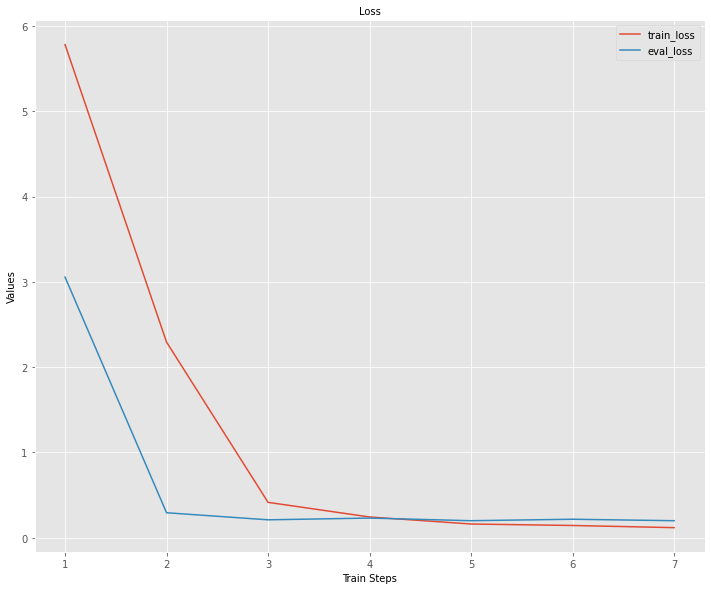

In [ ]:
#https://www.topbots.com/pretrain-transformers-models-in-pytorch/
import math
import numpy as np
import warnings
# Keep track of train and evaluate loss.
loss_history = {'train_loss':[], 'eval_loss':[]}

# Loop through each log history.
for log_history in trainer.state.log_history:
 
  if 'loss' in log_history.keys():
    # Deal with trianing loss.
    loss_history['train_loss'].append(log_history['loss'])

     
  elif 'eval_loss' in log_history.keys():
    # Deal with eval loss.
    loss_history['eval_loss'].append(log_history['eval_loss'])
 
 
# Plot Losses.
plot_dict(loss_history, start_step=1, 
          step_size=1, use_title='Loss', 
          use_xlabel='Train Steps', use_ylabel='Values')

### Evaluate

마지막 부분에서는 모델이 얼마나 잘 작동하는지 확인하기 위해 일부  validation data에 대해 모델을 실행합니다.

`processor` 와 `model`을 로드해 보겠습니다.


In [ ]:
processor = Wav2Vec2Processor.from_pretrained("obokkkk/wav2vec2-base-960h-timit-demo-colab")

https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/preprocessor_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpf_tdw75s


Downloading:   0%|          | 0.00/215 [00:00<?, ?B/s]

storing https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/preprocessor_config.json in cache at /root/.cache/huggingface/transformers/f226f46987277226f1e8abc6950560be2514a4c833e4cb593df05fccc2adbe2a.0e3e6656f99a6f7b9eddd943463eb7f34363640fce9e87b047ebd50d4b112b50
creating metadata file for /root/.cache/huggingface/transformers/f226f46987277226f1e8abc6950560be2514a4c833e4cb593df05fccc2adbe2a.0e3e6656f99a6f7b9eddd943463eb7f34363640fce9e87b047ebd50d4b112b50
loading feature extractor configuration file https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/f226f46987277226f1e8abc6950560be2514a4c833e4cb593df05fccc2adbe2a.0e3e6656f99a6f7b9eddd943463eb7f34363640fce9e87b047ebd50d4b112b50
Feature extractor Wav2Vec2FeatureExtractor {
  "do_normalize": true,
  "feature_extractor_type": "Wav2Vec2FeatureExtractor",
  "feature_size": 1,
  "padding_side": "right",
  "padd

Downloading:   0%|          | 0.00/268 [00:00<?, ?B/s]

storing https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/vocab.json in cache at /root/.cache/huggingface/transformers/3fa3f1268a416448ff8831ab46dcbfe56199e116f367bd9dbe8dc1a0e5b2d1f2.d7785e7aa8996c51449fed5e33657b573fcf612446169d75a8607247b9da5e19
creating metadata file for /root/.cache/huggingface/transformers/3fa3f1268a416448ff8831ab46dcbfe56199e116f367bd9dbe8dc1a0e5b2d1f2.d7785e7aa8996c51449fed5e33657b573fcf612446169d75a8607247b9da5e19
https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/tokenizer_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmplkqrmijq


Downloading:   0%|          | 0.00/181 [00:00<?, ?B/s]

storing https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/tokenizer_config.json in cache at /root/.cache/huggingface/transformers/f75636c5ad61cff660277e3153a17d0c7c79085f791c16b2efd9201ebea72e95.9a832b91e3d317e7bec01bab5134265b75f2d6b05a270d0140d8a116c51b8591
creating metadata file for /root/.cache/huggingface/transformers/f75636c5ad61cff660277e3153a17d0c7c79085f791c16b2efd9201ebea72e95.9a832b91e3d317e7bec01bab5134265b75f2d6b05a270d0140d8a116c51b8591
https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/special_tokens_map.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp4395w1nx


Downloading:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

storing https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/special_tokens_map.json in cache at /root/.cache/huggingface/transformers/3a46a3966298b3843643a0a4edc74f973d30b5790e17087045ceda1b7604f653.a21d51735cf8667bcd610f057e88548d5d6a381401f6b4501a8bc6c1a9dc8498
creating metadata file for /root/.cache/huggingface/transformers/3a46a3966298b3843643a0a4edc74f973d30b5790e17087045ceda1b7604f653.a21d51735cf8667bcd610f057e88548d5d6a381401f6b4501a8bc6c1a9dc8498
loading file https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/vocab.json from cache at /root/.cache/huggingface/transformers/3fa3f1268a416448ff8831ab46dcbfe56199e116f367bd9dbe8dc1a0e5b2d1f2.d7785e7aa8996c51449fed5e33657b573fcf612446169d75a8607247b9da5e19
loading file https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/f75636c5ad61cff660277e3153a17d0c7c79085f791c16b2efd9201ebea7

In [ ]:
model = Wav2Vec2ForCTC.from_pretrained("obokkkk/wav2vec2-base-960h-timit-demo-colab")

https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmp95dy2myf


Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

storing https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/79d55b50e7e573f533f0d714ed1c4b68bd8c0969ce85779398fbdc00802854a8.711396f9e432c0c049604e12d9b184cdb5a477eec87329f972ecf14090a9721e
creating metadata file for /root/.cache/huggingface/transformers/79d55b50e7e573f533f0d714ed1c4b68bd8c0969ce85779398fbdc00802854a8.711396f9e432c0c049604e12d9b184cdb5a477eec87329f972ecf14090a9721e
loading configuration file https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/79d55b50e7e573f533f0d714ed1c4b68bd8c0969ce85779398fbdc00802854a8.711396f9e432c0c049604e12d9b184cdb5a477eec87329f972ecf14090a9721e
Model config Wav2Vec2Config {
  "_name_or_path": "facebook/wav2vec2-base-960h",
  "activation_dropout": 0.1,
  "apply_spec_augment": true,
  "architectures": [
    "Wav2Vec2ForCTC"
  ],
  "attention_dropout": 0.1,
  "bos_tok

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

storing https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/b34f705bcf46c8ba66d6afbf971830276e175ce1f316131a60127585cbe9d49a.17512fbc62e6e1a196e7760932f6c649caeb151d9a5b2882a20f003b18611195
creating metadata file for /root/.cache/huggingface/transformers/b34f705bcf46c8ba66d6afbf971830276e175ce1f316131a60127585cbe9d49a.17512fbc62e6e1a196e7760932f6c649caeb151d9a5b2882a20f003b18611195
loading weights file https://huggingface.co/obokkkk/wav2vec2-base-960h-timit-demo-colab/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/b34f705bcf46c8ba66d6afbf971830276e175ce1f316131a60127585cbe9d49a.17512fbc62e6e1a196e7760932f6c649caeb151d9a5b2882a20f003b18611195
All model checkpoint weights were used when initializing Wav2Vec2ForCTC.

All the weights of Wav2Vec2ForCTC were initialized from the model checkpoint at obokkkk/wav2vec2-base-960h-timit-demo-colab.
If your task is sim

이제 'map(...)' 함수를 사용하여 모든 테스트 샘플의 전사를 예측하고 데이터 세트 자체에 예측을 저장합니다. 결과 사전을 `"results"`라고 부를 것입니다.

**참고**: 이 [issue](https://github.com/pytorch/fairseq/issues/3227)로 인해 의도적으로 `batch_size=1`로 테스트 데이터 세트를 평가합니다. 패딩된 입력은 패딩되지 않은 입력과 정확히 동일한 출력을 생성하지 않으므로 입력을 전혀 패딩하지 않음으로써 더 나은 WER을 얻을 수 있습니다.


In [ ]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"]).unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)
  
  return batch

In [ ]:
results = timit["test"].map(map_to_result, remove_columns=timit["test"].column_names)

0ex [00:00, ?ex/s]

Let's compute the overall WER now.

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

22.1% WER -  우리의 데모 모델은 아마도 공식  [leaderboard](https://paperswithcode.com/sota/speech-recognition-on-timit)에 올랐을 것입니다.

모델에서 어떤 오류가 발생하는지 보기 위해 몇 가지 예측을 살펴보겠습니다.

In [ ]:
show_random_elements(results)

,pred_str,text
0,aim to balance your employ you benefit package,aim to balance your employee benefit package
1,the fog prevented them from arriving on tom,the fog prevented them from arriving on time
2,young children should avoid exposure to contageous diseases,young children should avoid exposure to contagious diseases
3,artificial intelligence is for real,artificial intelligence is for real
4,their props were two step ladders a chair and a palm fan,their props were two stepladders a chair and a palm fan
5,if people were more generous there would be no need for welfare,if people were more generous there would be no need for welfare
6,the fish began to leap frantically on the surface of the small eakhe,the fish began to leap frantically on the surface of the small lake
7,her right hand eagches whenever the barametric pressure changes,her right hand aches whenever the barometric pressure changes
8,only lawyers love millionaires,only lawyers love millionaires
9,the nearest cenegade may not be within walkon distance,the nearest synagogue may not be within walking distance


예측된 전사가 정답 전사와 음향적으로 매우 유사하지만 종종 철자나 문법 오류가 포함되어 있음이 분명해집니다. 

우리가 언어 모델을 사용하지 않고 순수하게 Wav2Vec2에 의존한다는 점을 감안할 때 적절한 결과

Finally, to better understand how CTC works, it is worth taking a deeper look at the exact output of the model. Let's run the first test sample through the model, take the predicted ids and convert them to their corresponding tokens.

In [ ]:
model.to("cuda")

with torch.no_grad():
  logits = model(torch.tensor(timit["test"][:1]["input_values"], device="cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))

출력은 CTC가 실제로 어떻게 작동하는지 좀 더 명확하게 해야 합니다. 모델은 분류할 음성 청크가 여전히 동일한 토큰에 해당하는 경우 동일한 토큰을 반복하는 방법을 배웠기 때문에 말하기 속도에 어느 정도 불변합니다. 이는 음성 파일의 전사가 길이와 거의 무관한 경우가 많기 때문에 CTC를 음성 인식을 위한 매우 강력한 알고리즘으로 만듭니다.

독자들에게 CTC를 더 잘 이해하기 위해 [this](https://distill.pub/2017/ctc) 아주 멋진 블로그 게시물을 살펴보기를 다시 권합니다.